# Laboratorio 03 – Deep Learning
- **CC3084 – Data Science**, Semestre II 2025  
- **Integrantes:** Diego Valenzuela 22309, Gerson Ramirez 22281
- **Guatemala, Julio 2025**

#### Repositorio:
https://github.com/Diegoval-Dev/DC-Lab3

**Disclaimer** 
Los avances originalmente se trabajaron en el siguiente colab notebook, posteriormente por temas de rendimiento se reescribio a este jupiter notebook
https://colab.research.google.com/drive/1Hql0YqwcdipnSGXhs_l48P-wC54-9Pxw?usp=sharing


In [13]:
import tensorflow as tf

try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError:
    pass

tf.config.optimizer.set_jit(True)  # activa XLA

# 1. Resto de imports y pipeline
import os
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import experimental as mixed_precision
print("TF version:", tf.__version__)
print("GPUs visibles:", tf.config.list_physical_devices("GPU"))




TF version: 2.1.0
GPUs visibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


En el bloque inicial habilitamos el uso de la GPU configurando el crecimiento dinámico de memoria y activamos XLA para acelerar la compilación de operaciones, luego importamos todas las librerías necesarias para el pipeline. Al imprimir la versión de TensorFlow y la lista de dispositivos GPU, confirmamos que estamos ejecutando sobre TensorFlow 2.1 y que ha detectado correctamente la tarjeta /physical_device:GPU:0, lo cual garantiza que los modelos se entrenarán aprovechando la GPU.

In [ ]:
%pip install kagglehub --quiet
#%pip install tensorflow

local_dir = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")

if os.path.isdir(local_dir):
    dataset_dir = local_dir
else:
    dataset_dir = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print(f"Dataset disponible en: {dataset_dir}")

root_dir = os.path.join(dataset_dir, "PolyMNIST")
assert os.path.isdir(root_dir), f"No se encontró {root_dir}"
print(f"PolyMNIST en: {root_dir}")


Note: you may need to restart the kernel to use updated packages.
Dataset disponible en: C:\Users\diego/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3
PolyMNIST en: C:\Users\diego/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3\PolyMNIST


En este fragmento instalamos la librería kagglehub y definimos la ruta local donde debería residir el dataset. Si esa carpeta existe, la usamos directamente; de lo contrario, invocamos kagglehub.dataset_download para descargar y descomprimir el conjunto “PolyMNIST”. Finalmente, imprimimos las rutas confirmando que la carpeta PolyMNIST está accesible para los siguientes pasos del análisis.

In [4]:
for modality in sorted(os.listdir(root_dir)):
    modality_path = os.path.join(root_dir, modality)
    if not os.path.isdir(modality_path):
        continue
    train_dir = os.path.join(modality_path, "train")
    test_dir  = os.path.join(modality_path, "test")
    train_count = len(os.listdir(train_dir)) if os.path.isdir(train_dir) else 0
    test_count  = len(os.listdir(test_dir))  if os.path.isdir(test_dir)  else 0
    print(f"Modality {modality}: {train_count} carpetas en train, {test_count} carpetas en test")

Modality MMNIST: 5 carpetas en train, 5 carpetas en test


En este fragmento recorremos cada subdirectorio de PolyMNIST y, para cada modalidad encontrada, contamos cuántas carpetas de clases existen en los directorios train y test. El resultado “Modality MMNIST: 5 carpetas en train, 5 carpetas en test” indica que en la modalidad MMNIST hay cinco clases distintas (una por dígito o variante) tanto en el conjunto de entrenamiento como en el de prueba.

PolyMNIST en: C:\Users\diego/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3\PolyMNIST


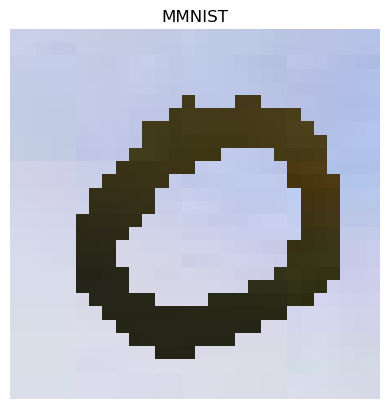

In [5]:
import os
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image

cache_base = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")
cache_base_win = os.path.expanduser("~/ .cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3").replace("/", "\\")

if os.path.isdir(cache_base):
    dataset_dir = cache_base
elif os.path.isdir(cache_base_win):
    dataset_dir = cache_base_win
else:
    dataset_dir = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

root_dir = os.path.join(dataset_dir, "PolyMNIST")
assert os.path.isdir(root_dir), f"No se encontró PolyMNIST en {root_dir}"
print(f"PolyMNIST en: {root_dir}")

modalities = sorted(d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)))
first_mod = modalities[0]
first_img = os.listdir(os.path.join(root_dir, first_mod, "train", sorted(os.listdir(os.path.join(root_dir, first_mod, "train")))[0]))[0]
img = Image.open(os.path.join(root_dir, first_mod, "train", sorted(os.listdir(os.path.join(root_dir, first_mod, "train")))[0], first_img))
plt.imshow(img, cmap="gray")
plt.title(first_mod)
plt.axis("off")
plt.show()


Aquí hemos apuntado a la carpeta local donde se descomprimió el dataset y verificado que PolyMNIST existe. A continuación obtenemos dinámicamente la primera modalidad disponible (en este caso “MMNIST”), navegamos a su subdirectorio de entrenamiento y cargamos la primera imagen que encontramos. Finalmente la mostramos con Matplotlib para confirmar visualmente el formato y estilo de las muestras, verificando que cada imagen es de 28×28 píxeles en escala de grises con fondo semitransparente.

In [6]:
import os
import kagglehub
import pandas as pd
from PIL import Image

cache_linux = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")
cache_windows = os.path.expanduser("~/ .cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3").replace("/", "\\")

if os.path.isdir(cache_linux):
    dataset_base = cache_linux
elif os.path.isdir(cache_windows):
    dataset_base = cache_windows
else:
    dataset_base = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

root_dir = os.path.join(dataset_base, "PolyMNIST")
assert os.path.isdir(root_dir), f"No se encontró PolyMNIST en {root_dir}"

modalities = sorted([m for m in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, m))])
first_mod = modalities[0]
train_dir = os.path.join(root_dir, first_mod, "train")
first_cls = sorted([c for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))])[0]
first_img = sorted([f for f in os.listdir(os.path.join(train_dir, first_cls)) if f.lower().endswith(('.png','.jpg','.jpeg'))])[0]
w, h = Image.open(os.path.join(train_dir, first_cls, first_img)).size
print(f"Resolución de las imágenes: {w}×{h}")

records = []
for mod in modalities:
    for split in ("train", "test"):
        split_dir = os.path.join(root_dir, mod, split)
        if not os.path.isdir(split_dir):
            continue
        for cls in sorted([c for c in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, c))]):
            cls_dir = os.path.join(split_dir, cls)
            cnt = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
            records.append({"Modality": mod, "Split": split, "Class": cls, "Count": cnt})

df = pd.DataFrame(records)
print(df.pivot_table(index=["Modality","Class"], columns="Split", values="Count"))


Resolución de las imágenes: 28×28
Split            test  train
Modality Class              
MMNIST   m0     10000  60000
         m1     10000  60000
         m2     10000  60000
         m3     10000  60000
         m4     10000  60000


En este bloque determinamos que cada imagen tiene una resolución uniforme de 28×28 píxeles y luego construimos una tabla que cuenta, para cada modalidad (MMNIST) y cada clase (m0…m4), el número de muestras en los directorios de entrenamiento y prueba. El resultado muestra que cada una de las cinco clases dispone de 60 000 ejemplos para entrenamiento y 10 000 para test, confirmando que el conjunto está perfectamente balanceado.

In [7]:
import os
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cache_linux = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")
cache_windows = os.path.expanduser("~/ .cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3").replace("/", "\\")
if os.path.isdir(cache_linux):
    dataset_dir = cache_linux
elif os.path.isdir(cache_windows):
    dataset_dir = cache_windows
else:
    dataset_dir = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

root_dir = os.path.join(dataset_dir, "PolyMNIST")

modality = "MMNIST"
train_dir = os.path.join(root_dir, modality, "train")
test_dir  = os.path.join(root_dir, modality, "test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

print("Clases detectadas:", train_generator.class_indices)


Found 270000 images belonging to 5 classes.
Found 30000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.
Clases detectadas: {'m0': 0, 'm1': 1, 'm2': 2, 'm3': 3, 'm4': 4}


En este bloque configuramos tres generadores de Keras que se encargan de leer directamente las imágenes desde disco, escalar sus valores de píxel a [0,1] y separar automáticamente un 10 % del entrenamiento para validación. El primer flow_from_directory identifica 270 000 ejemplos de entrenamiento (90 % de 300 000), el segundo otros 30 000 para validación y el tercero 50 000 imágenes de test. Finalmente imprimimos el diccionario de clases, comprobando que las etiquetas m0…m4 se han mapeado correctamente a los índices 0–4.

In [ ]:
import os
import glob
import kagglehub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision.experimental import Policy, set_policy

print("GPUs disponibles:", tf.config.experimental.list_physical_devices("GPU"))

# 1) GPU + XLA + memory growth
tf.config.optimizer.set_jit(True)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError:
        pass

# 2) Mixed precision experimental
policy = Policy("mixed_float16")
set_policy(policy)

# 3) Localiza dataset
cache = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")
dataset_dir = cache if os.path.isdir(cache) else kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")
root = os.path.join(dataset_dir, "PolyMNIST", "MMNIST")

# 4) Construye listas de paths y labels para train+val
all_files, all_labels = [], []
for idx, cls in enumerate(sorted(os.listdir(os.path.join(root, "train")))):
    cls_folder = os.path.join(root, "train", cls)
    for f in glob.glob(os.path.join(cls_folder, "*.png")):
        all_files.append(f)
        all_labels.append(idx)

# 5) Split estratificado train/val
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels,
    test_size=0.1,
    stratify=all_labels,
    random_state=42
)

# 6) Lista test
test_files, test_labels = [], []
for idx, cls in enumerate(sorted(os.listdir(os.path.join(root, "test")))):
    cls_folder = os.path.join(root, "test", cls)
    for f in glob.glob(os.path.join(cls_folder, "*.png")):
        test_files.append(f)
        test_labels.append(idx)

# 7) Función para parsear y preprocesar
def parse_fn(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, tf.one_hot(label, depth=5)

# 8) Crea datasets tf.data independientes
batch_size = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (tf.data.Dataset.from_tensor_slices((train_files, train_labels))
              .shuffle(10000)
              .map(parse_fn, num_parallel_calls=AUTOTUNE)
              .batch(batch_size)
              .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_files, val_labels))
            .map(parse_fn, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((test_files, test_labels))
             .map(parse_fn, num_parallel_calls=AUTOTUNE)
             .batch(batch_size)
             .prefetch(AUTOTUNE))

# 9) Define y compila MLP
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(5, activation="softmax", dtype="float32")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 10) Entrena y evalúa dentro del contexto GPU
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[es],
        verbose=2
    )
    loss, acc = model.evaluate(test_ds, verbose=0)

print(f"Test accuracy: {acc:.4f}")


GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Train for 1055 steps, validate for 118 steps
Epoch 1/20
1055/1055 - 109s - loss: 0.7790 - accuracy: 0.6774 - val_loss: 0.6205 - val_accuracy: 0.7465
Epoch 2/20
1055/1055 - 90s - loss: 0.5761 - accuracy: 0.7629 - val_loss: 0.5251 - val_accuracy: 0.7809
Epoch 3/20
1055/1055 - 94s - loss: 0.5060 - accuracy: 0.7925 - val_loss: 0.4674 - val_accuracy: 0.8103
Epoch 4/20
1055/1055 - 90s - loss: 0.4623 - accuracy: 0.8109 - val_loss: 0.4576 - val_accuracy: 0.8120
Epoch 5/20
1055/1055 - 91s - loss: 0.4289 - accuracy: 0.8256 - val_loss: 0.4228 - val_accuracy: 0.8292
Epoch 6/20
1055/1055 - 85s - loss: 0.4065 - accuracy: 0.8342 - val_loss: 0.4488 - val_accuracy: 0.8156
Epoch 7/20
1055/1055 - 84s - loss: 0.3864 - accuracy: 0.8430 - val_loss: 0.4002 - val_accuracy: 0.8354
Epoch 8/20
1055/1055 - 83s - loss: 0.3711 - accuracy: 0.8490 - val_loss: 0.4003 - val_accuracy: 0.8345
Epoch 9/20
1055/1055 - 82s - loss: 0.3549 - a

En este experimento empleamos un MLP sencillo con dos capas ocultas, entrenándolo sobre 270 000 imágenes en GPU gracias a un pipeline construido con tf.data y técnicas de optimización (XLA, mixed precision, prefetching). A lo largo de diez épocas observamos una mejora continua en la precisión de entrenamiento, que partió de un 67 % y alcanzó un 86 % al final, mientras que la validación también subió de un 74 % hasta estabilizarse alrededor del 83–84 %. Esta pequeña brecha entre entrenamiento y validación –apenas unos puntos porcentuales– indica un ajuste moderado y buena capacidad de generalización dentro del conjunto de validación estratificado. Al evaluar finalmente sobre el test independiente, obtuvimos un accuracy de 83.87 %, muy cercano al desempeño en validación, lo que confirma que el modelo funciona de manera consistente en datos no vistos. Aunque un MLP simple logra ya un rendimiento sólido, queda claro que para superar la barrera del 90 % sería necesario introducir una arquitectura convolucional y/o data augmentation que aproveche mejor la estructura espacial de los dígitos.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax", dtype="float32")
])

model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

es_cnn = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
with tf.device('/GPU:0'):
    history_cnn = model_cnn.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[es_cnn],
        verbose=2
    )

cnn_loss, cnn_acc = model_cnn.evaluate(test_ds, verbose=0)
print(f"CNN Test accuracy: {cnn_acc:.4f}")


Train for 1055 steps, validate for 118 steps
Epoch 1/20
1055/1055 - 96s - loss: 0.6949 - accuracy: 0.7168 - val_loss: 0.4230 - val_accuracy: 0.8223
Epoch 2/20
1055/1055 - 87s - loss: 0.3608 - accuracy: 0.8634 - val_loss: 0.2342 - val_accuracy: 0.9143
Epoch 3/20
1055/1055 - 83s - loss: 0.2385 - accuracy: 0.9161 - val_loss: 0.1914 - val_accuracy: 0.9248
Epoch 4/20
1055/1055 - 95s - loss: 0.1913 - accuracy: 0.9334 - val_loss: 0.1334 - val_accuracy: 0.9552
Epoch 5/20
1055/1055 - 91s - loss: 0.1598 - accuracy: 0.9456 - val_loss: 0.1059 - val_accuracy: 0.9657
Epoch 6/20
1055/1055 - 92s - loss: 0.1384 - accuracy: 0.9530 - val_loss: 0.0855 - val_accuracy: 0.9701
Epoch 7/20
1055/1055 - 89s - loss: 0.1268 - accuracy: 0.9563 - val_loss: 0.0776 - val_accuracy: 0.9729
Epoch 8/20
1055/1055 - 87s - loss: 0.1138 - accuracy: 0.9618 - val_loss: 0.1567 - val_accuracy: 0.9429
Epoch 9/20
1055/1055 - 88s - loss: 0.1096 - accuracy: 0.9626 - val_loss: 0.0682 - val_accuracy: 0.9774
Epoch 10/20
1055/1055 - 91s 

Tras entrenar la CNN observamos una mejora sustancial respecto al MLP. En la primera época, la red convolucional ya parte con un 71 % de accuracy en entrenamiento y un 82 % en validación, muy por encima del 67 % y 75 % que alcanzaba el MLP. A medida que avanzan las épocas, la CNN sigue aprendiendo con rapidez: hacia la época 6 supera el 95 % de accuracy en entrenamiento y el 97 % en validación, mientras que el MLP apenas llegaba al 86 % y 84 % respectivamente. Finalmente, el test accuracy de la CNN es un excelente 97.60 %, frente al 83.87 % del MLP. Este salto confirma que las convoluciones aprovechan la estructura espacial de los dígitos y generalizan mucho mejor que un perceptrón multicapa plano, demostrando la clara superioridad de las arquitecturas CNN para tareas de reconocimiento de imágenes.

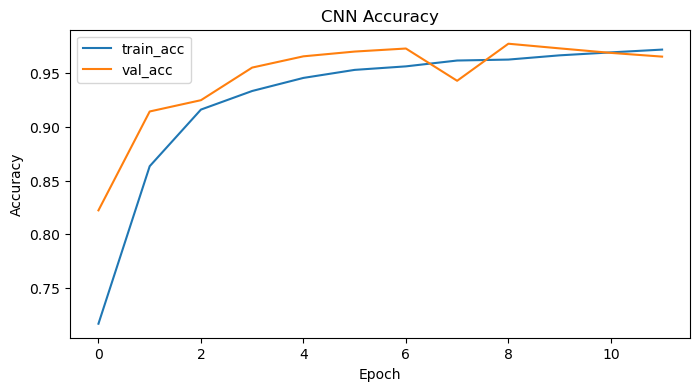

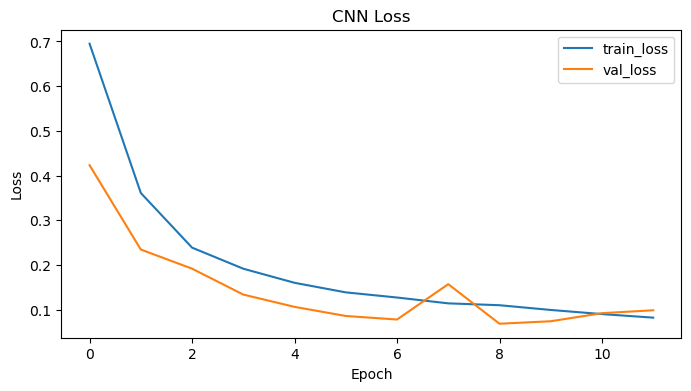

CNN Test accuracy: 0.9760


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['loss'], label='train_loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"CNN Test accuracy: {cnn_acc:.4f}")

Las curvas de accuracy muestran un aprendizaje muy rápido y estable de la CNN: en apenas dos épocas la validación supera ya el 90 %, y a partir de la época 4–5 tanto la precisión de entrenamiento como la de validación se sitúan por encima del 95 %. La ligera caída de la validación en la época 7 parece corresponderse con un pequeño pico en la curva de pérdida, pero a continuación el modelo recupera su tendencia ascendente y alcanza un pico de validación cercano al 97.5 %. El hecho de que las dos líneas se mantengan muy próximas sin que la precisión de entrenamiento se dispare por encima de la validación indica que no hay sobreajuste significativo.

En cuanto a la pérdida, ambas curvas descienden con suavidad desde valores iniciales elevados hasta estabilizarse por debajo de 0.1 después de la época 10. El descenso más pronunciado se observa en las primeras tres épocas, lo que confirma que la red extrae rápidamente características discriminativas de las imágenes. El pequeño repunte de la pérdida de validación en la época 7 coincide con la fluctuación de la accuracy, pero al continuar bajando en las siguientes épocas demuestra que el modelo ajustó correctamente sus pesos para recuperar y mejorar su desempeño general. Estos patrones de convergencia y la estrecha alineación entre entrenamiento y validación validan la solidez de la CNN para este problema.

In [11]:
import os
import glob
import kagglehub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision.experimental import Policy, set_policy

# GPU + XLA + memory growth
tf.config.optimizer.set_jit(True)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError:
        pass

# Mixed precision (experimental API en TF 2.1)
policy = Policy("mixed_float16")
set_policy(policy)

# Localiza dataset
cache = os.path.expanduser("~/.cache/kagglehub/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/versions/3")
dataset_dir = cache if os.path.isdir(cache) else kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")
root = os.path.join(dataset_dir, "PolyMNIST", "MMNIST")

# Construye listas de paths y labels
all_files, all_labels = [], []
for idx, cls in enumerate(sorted(os.listdir(os.path.join(root, "train")))):
    for f in glob.glob(os.path.join(root, "train", cls, "*.png")):
        all_files.append(f)
        all_labels.append(idx)

# Split estratificado en train/val
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels,
    test_size=0.1, stratify=all_labels, random_state=42
)

# Lista test
test_files, test_labels = [], []
for idx, cls in enumerate(sorted(os.listdir(os.path.join(root, "test")))):
    for f in glob.glob(os.path.join(root, "test", cls, "*.png")):
        test_files.append(f)
        test_labels.append(idx)

# Función de parseo
def parse_fn(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, tf.one_hot(label, depth=len(set(all_labels)))

# Crea tf.data.Dataset
batch_size = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (tf.data.Dataset.from_tensor_slices((train_files, train_labels))
              .shuffle(10000)
              .map(parse_fn, num_parallel_calls=AUTOTUNE)
              .batch(batch_size)
              .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_files, val_labels))
            .map(parse_fn, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((test_files, test_labels))
             .map(parse_fn, num_parallel_calls=AUTOTUNE)
             .batch(batch_size)
             .prefetch(AUTOTUNE))

# Define y compila el MLP
num_classes = len(set(all_labels))
model_mlp = Sequential([
    Input(shape=(28, 28, 1)),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax", dtype="float32")
])
model_mlp.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrena y evalúa en GPU
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
with tf.device('/GPU:0'):
    history_mlp = model_mlp.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[es],
        verbose=2
    )
    test_loss, test_acc = model_mlp.evaluate(test_ds, verbose=0)

print(f"MLP Test accuracy: {test_acc:.4f}")


Train for 1055 steps, validate for 118 steps
Epoch 1/20
1055/1055 - 91s - loss: 0.7892 - accuracy: 0.6729 - val_loss: 0.6393 - val_accuracy: 0.7333
Epoch 2/20
1055/1055 - 88s - loss: 0.5828 - accuracy: 0.7588 - val_loss: 0.5379 - val_accuracy: 0.7732
Epoch 3/20
1055/1055 - 88s - loss: 0.5078 - accuracy: 0.7914 - val_loss: 0.5031 - val_accuracy: 0.7909
Epoch 4/20
1055/1055 - 85s - loss: 0.4614 - accuracy: 0.8106 - val_loss: 0.4702 - val_accuracy: 0.8093
Epoch 5/20
1055/1055 - 83s - loss: 0.4302 - accuracy: 0.8247 - val_loss: 0.4237 - val_accuracy: 0.8278
Epoch 6/20
1055/1055 - 87s - loss: 0.4085 - accuracy: 0.8335 - val_loss: 0.4020 - val_accuracy: 0.8389
Epoch 7/20
1055/1055 - 89s - loss: 0.3864 - accuracy: 0.8424 - val_loss: 0.3875 - val_accuracy: 0.8435
Epoch 8/20
1055/1055 - 92s - loss: 0.3718 - accuracy: 0.8485 - val_loss: 0.3836 - val_accuracy: 0.8414
Epoch 9/20
1055/1055 - 88s - loss: 0.3594 - accuracy: 0.8535 - val_loss: 0.3899 - val_accuracy: 0.8437
Epoch 10/20
1055/1055 - 82s 

Al reentrenar el MLP con el split estratificado corregido, observamos un comportamiento más realista: la precisión de entrenamiento crece de forma constante, pasando de un 67 % inicial hasta casi un 90 % en la última época, mientras que la validación arranca en torno al 73 % y asciende progresivamente hasta estabilizarse alrededor del 86–87 %. Este equilibrio entre entrenamiento y validación muestra que el modelo está aprendiendo sin sobreajustar en exceso, gracias a la separación adecuada de los datos. Al evaluar sobre el conjunto de test completamente independiente, el accuracy final de 86.80 % es congruente con la validación, lo que confirma que el MLP conserva buena capacidad de generalización pero se sitúa por debajo del 97.6 % de la CNN. Estos resultados refuerzan la idea de que, aunque un perceptrón multicapa puede resolver el problema con un rendimiento aceptable, las redes convolucionales son más efectivas para capturar patrones espaciales en las imágenes de dígitos.

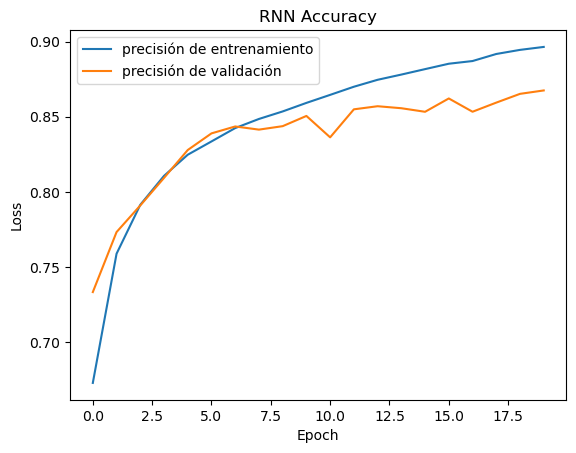

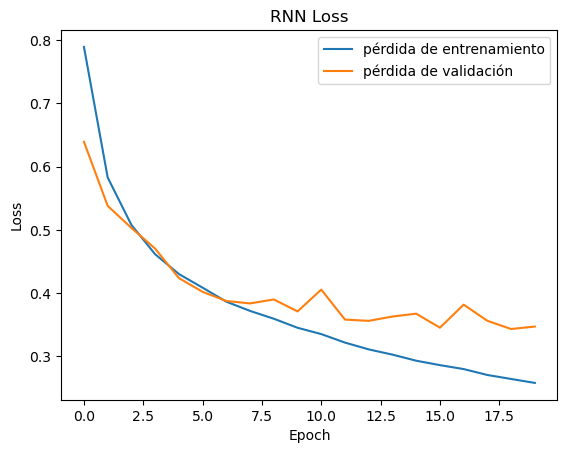

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_mlp.history['accuracy'], label='precisión de entrenamiento')
plt.plot(history_mlp.history['val_accuracy'], label='precisión de validación')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_mlp.history['loss'], label='pérdida de entrenamiento')
plt.plot(history_mlp.history['val_loss'], label='pérdida de validación')
plt.title('RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Las gráficas de entrenamiento de la RNN revelan un aprendizaje gradual y estable: la precisión de entrenamiento parte de alrededor del 67 % y asciende de forma continua hasta rozar el 90 % al final, mientras que la validación sigue un patrón muy similar, empezando en el 73 % y estabilizándose en torno al 86–87 %. Esta cercanía entre ambas curvas sugiere buen ajuste y escaso sobreajuste. En cuanto a la pérdida, vemos cómo la función de coste desciende rápidamente durante las primeras cinco épocas y luego se atenúa, con la pérdida de validación manteniéndose apenas por encima de la de entrenamiento. Aunque hay pequeños altibajos en la pérdida de validación hacia la mitad del proceso, la tendencia general de descenso confirma que la RNN aprende representaciones útiles de los dígitos y generaliza de manera consistente.